#V2 @ horacio

In [2]:
# will be v39

import os
from utils.Auger.SD import Monit, SdHisto
from utils.binaries import *
from utils.plotting import *

source = "/cr/data01/filip/Data/daqIntegrationTests/v34/"
monit_data = [source + file for file in os.listdir(source) if file.startswith("mc")]
event_data = np.loadtxt(f"{source}/peak.txt", usecols=range(4, 154))
timestamps = np.loadtxt(f"{source}/peak.txt", usecols=[2])
rate_data = np.loadtxt(f"{source}/calib.test", unpack=True)
monit = Monit(*monit_data)

timestamps = [t[0] for t in np.split(timestamps, len(timestamps) / 4)]
event_data = np.split(event_data, len(event_data) / 4)
assert len(event_data) == len(timestamps), "Reading data failed =("

12:01:38 (  +22.8s) [INFO   ] -- import logging
12:01:38 (    +3ms) [INFO   ] -- import numpy as np
12:01:38 (    +7ms) [INFO   ] -- import uncertainties
12:01:38 (    +3ms) [INFO   ] -- import numpy as np
12:01:38 (    +7ms) [INFO   ] -- import uncertainties
12:01:39 (  +217ms) [INFO   ] -- import pandas as pd
12:01:39 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
12:01:39 (    +2ms) [INFO   ] -- import binaries.tools as tools
12:01:39 (  +650ms) [INFO   ] -- import matplotlib.pyplot as plt
12:01:39 (   +24ms) [INFO   ] -- import seaborn as so
12:01:39 (    +2ms) [INFO   ] -- import plotting.tools as plot
12:01:39 (    +6ms) [DEBUG  ] -- font size set to 9.5
12:01:39 (    +1ms) [DEBUG  ] -- label size set to 13.0
12:01:39 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
12:01:39 (    +1ms) [DEBUG  ] -- markersize set to 2.0
12:01:39 (    +1ms) [DEBUG  ] -- usetex set to False
12:01:39 (   +54ms) [INFO   ] -- received 2 file(s) as input
12:01:40 (  +216ms) [I

12:01:43 (   +3.2s) [INFO   ] -- received 3 file(s) as input
12:01:43 (  +458ms) [INFO   ] -- View monit keys with self.keys()
12:01:43 (   +67ms) [INFO   ] -- found 422 entries for key fTime and station #609
12:01:43 (   +13ms) [INFO   ] -- found 422 entries for key fPeak and station #609


WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit faile

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit faile

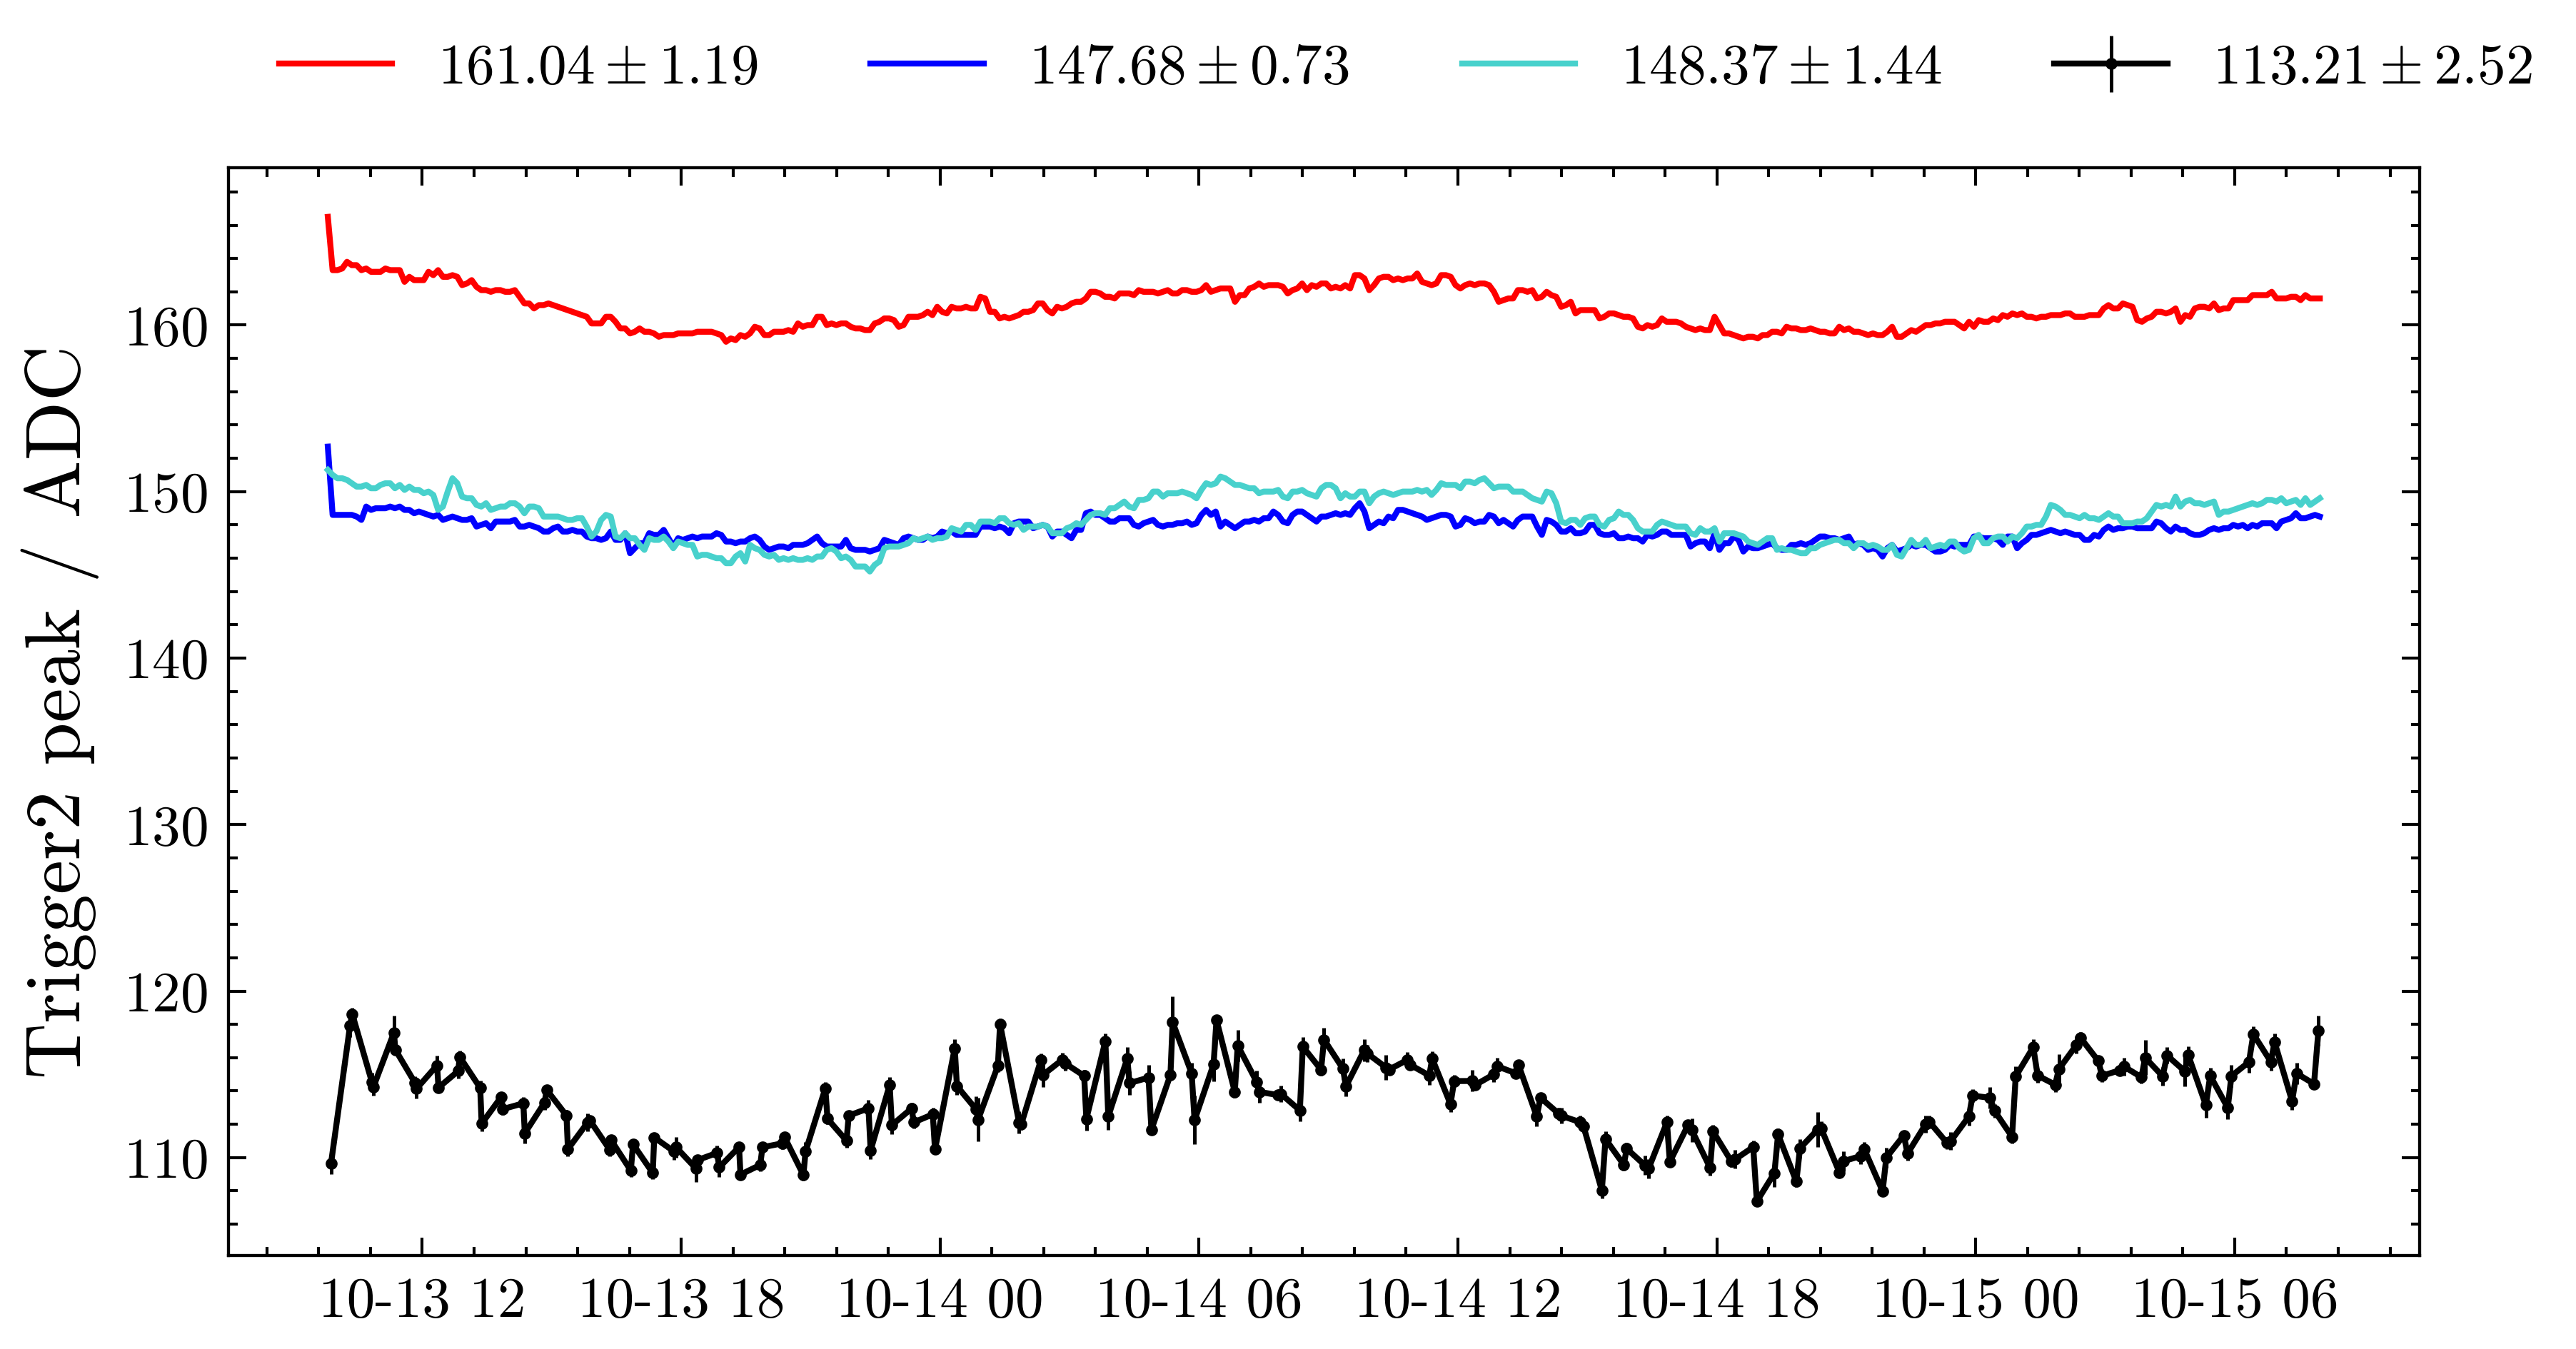

In [3]:
errorbar_kwargs = [
    {"marker": "x", "c": "r"},
    {"marker": "^", "c": "b"},
    {"marker": "*", "c": "mediumturquoise"},
    {"marker": "o", "c": "k"},
]

f = 1
version = "v39"
base = f"/cr/data01/filip/Data/daqIntegrationTests/{version}/"
monit_files = [base + file for file in os.listdir(base) if "mc" in file]

monit = Monit(*monit_files)
t, wcds = (
    monit("fTime", 609 if version >= "v36" else 136),
    monit("fPeak", 609 if version >= "v36" else 136).T,
)


idxs = np.argsort(t)
t, (wcd1, wcd2, wcd3) = t[idxs], [w[idxs] for w in wcds]
mask = wcd3 != 0

_, t_acq, t_gps, pmt, *histos = np.loadtxt(
    f"/cr/data01/filip/Data/daqIntegrationTests/{version}/peak.txt", unpack=True
)
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)

# to convert from filtered & downsampled to full bandwidth

ax1.plot(
    plot.to_datetime(t[mask]),
    wcd1[mask],
    c="r",
    label=rf"${np.mean(wcd1[mask]):.2f}\pm{np.std(wcd1[mask]):.2f}$",
    ls="solid",
)
ax1.plot(
    plot.to_datetime(t[mask]),
    wcd2[mask],
    c="b",
    label=rf"${np.mean(wcd2[mask]):.2f}\pm{np.std(wcd2[mask]):.2f}$",
    ls="solid",
)
ax1.plot(
    plot.to_datetime(t[mask]),
    wcd3[mask],
    c="mediumturquoise",
    label=rf"${np.mean(wcd3[mask]):.2f}\pm{np.std(wcd3[mask]):.2f}$",
    ls="solid",
)
ax1.plot([], [], c="k", ls="solid")


histos = np.split(np.array(histos).T, len(histos[0]) / 4)
t_gps = np.split(t_gps, len(t_gps) / 4)

c = ["r", "b", "mediumturquoise", "k"]
t_asd, mip, err = [], [], []
for i, (tx, histo) in enumerate(zip(t_gps, histos)):
    histo = SdHisto(peak=histo)
    peaks = histo.fit()["peak"]

    ppeak, eerr = peaks[3][1].n * 3, peaks[3][1].std_dev
    mip.append(ppeak), err.append(eerr)
    t_asd.append(tx[0])

ax1.errorbar(
    plot.to_datetime(t_asd),
    mip,
    err,
    ms=1,
    elinewidth=0.6,
    label=rf"${np.mean(mip):.2f}\pm{np.std(mip):.2f}$",
    **errorbar_kwargs[3],
)

ax1_twin = ax1.twinx()
ax1_twin.legend()
ax1_twin.set_ylim(*ax1.get_ylim())
ax1_twin.set_yticklabels([])

ax1.set_ylabel("Trigger2 peak / ADC")
ax1.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", ncol=4)
# ax1.legend(title='Xb')
# ax2.legend(title='MuonFill'

In [13]:
peaks = [161.04, 147, 68, 148.37, 113.21 / 3]
noise_data = np.loadtxt(f"{source}/calib.test")
dt = np.diff(noise_data[:, 0])
mask = dt <= 61

dt = dt[mask]
noise_data = noise_data[1:][mask]

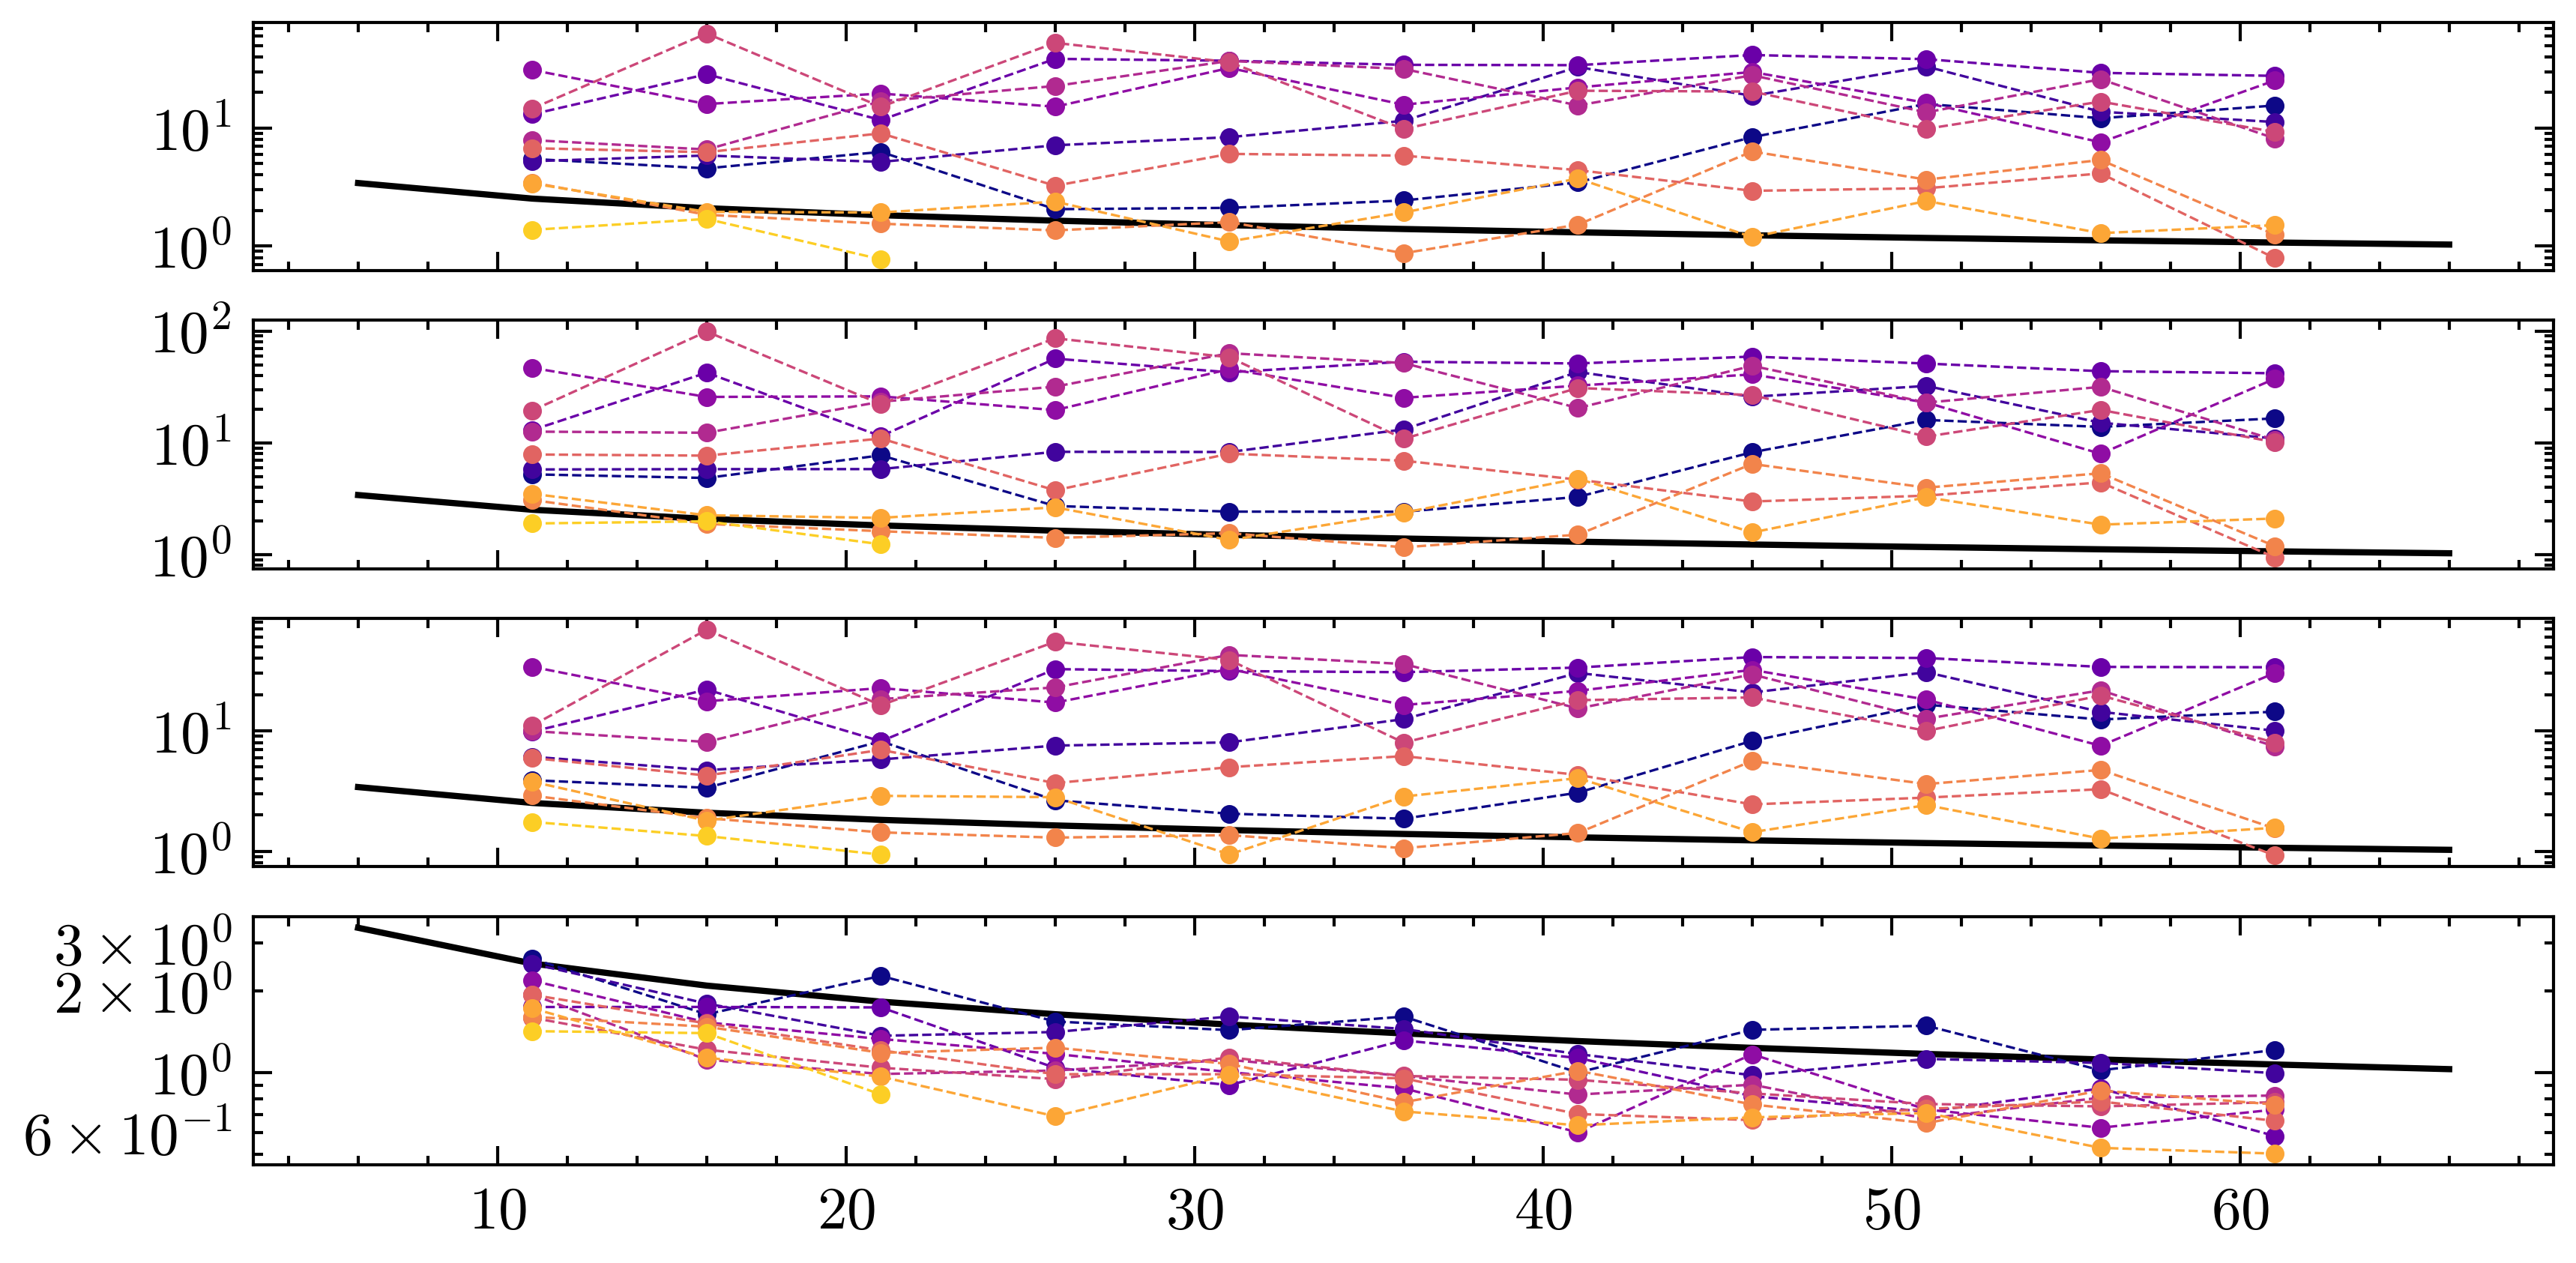

In [33]:
fig, axes = plt.subplots(4, 1, sharex=True)
n_thresholds = len(np.unique(noise_data[:, 1]))
c = plot.gradient(plt.cm.plasma, n_thresholds)
dt_vals = np.arange(6, 67, 5)

for i in range(4):

    pmt_noise = noise_data[:, 2 * i + 2]
    pmt_threshold = noise_data[:, 2 * i + 1]

    for j, thresh in enumerate(np.unique(pmt_threshold)):
        noise = []
        for time in dt_vals:
            this = np.logical_and(pmt_threshold == thresh, dt == time)
            noise.append(np.std(pmt_noise[this]))

        axes[i].errorbar(dt_vals, noise, c=c[j], fmt="--o", lw=0.4, ms=2)

    axes[i].plot(dt_vals, np.sqrt(70 / dt_vals))
    axes[i].set_yscale("log")

In [21]:
print(np.unique(dt))

[11. 16. 21. 26. 31. 36. 41. 42. 46. 51. 52. 56. 61.]


In [ ]:
# normalized to VEM/MIP

# thresholds_calibrated[i] = PMT threshold in units of VEM/MIP
# dt                       = acq. time for onlinecalib values
# rates                    = rates in the PMT muon buffers

import matplotlib as mpl

NBINS = 20

dt = np.diff(times)
rates = rate_data[2::2]
t_vals = np.arange(11, 62, 5)
axes = [plt.subplots()[1] for _ in range(4)]
min_max = lambda x: (np.min(x), np.max(x) + 1e-5)
colors = plot.gradient(plt.cm.plasma, NBINS)

assert (
    len(thresholds_calibrated[0]) == len(rate_data[0]) == len(dt) + 1
), "error reading data =("

for pmt in range(4):

    this_rates = rates[pmt][1:]
    this_thresholds = thresholds_calibrated[pmt][1:]
    bins = np.linspace(*min_max(this_thresholds), NBINS + 1)

    bin_indices = np.digitize(this_thresholds, bins)

    for i in range(NBINS):
        noise = [[] for _ in range(len(t_vals))]
        i_mask = bin_indices == i

        for j, k in enumerate(t_vals):
            mask = np.logical_and(dt == k, i_mask)
            noise[j].append(np.std(this_rates[mask], ddof=1))

        axes[pmt].errorbar(t_vals, noise, c=colors[i], ls="--", ms=2, marker="o")
        X = np.linspace(7, 65, 58)

    axes[pmt].set_xlabel("$t_\mathrm{acq.}$ / s")
    axes[pmt].set_ylabel("$\sigma_{\mathrm{T}70}$ / Hz")
    axes[pmt].scatter([], [], c="k", ls="solid", label="Data")
    axes[pmt].plot(X, np.sqrt(70 / X), c="k", ls="solid", label="Poisson")

    norm = mpl.colors.Normalize(vmin=bins[0], vmax=bins[-2])
    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    plt.colorbar(
        sm,
        ticks=bins[:-1],
        boundaries=bins[:-1],
        ax=axes[pmt],
        label=r"SB trigger threshold / $I_\mathrm{Rate}$",
    )

In [ ]:
# raw threshold values
import matplotlib as mpl

colors = plot.gradient(plt.cm.plasma, 10)
axes = [plt.subplots()[1] for _ in range(4)]

thresholds, rates = rate_data[1::2], rate_data[2::2]
dt = np.diff(rate_data[0])

for i, ax in enumerate(axes):
    rate, threshold = rates[i][1:], thresholds[i][1:]
    time, noise = [[] for _ in range(10)], [[] for _ in range(10)]
    X = np.linspace(7, 65, 58)
    ax.plot(X, np.sqrt(70 / X), c="k", ls="solid")

    # ax.set_yscale('log')
    ax.plot([], [], label="Poisson")
    ax.scatter([], [], label="Data")
    ax.set_xlabel("acq. time / s")
    ax.set_ylabel(r"$\sigma_\mathrm{T70}$ / ADC")
    ax.legend()

    for j, th in enumerate(np.unique(threshold)):
        for t in np.unique(dt):
            if t > 61:
                continue

            mask = np.logical_and(threshold == th, dt == t)
            this_noise = rate[mask]

            if len(this_noise) < 5:
                continue

            noise[j].append(np.std(this_noise, ddof=1))
            time[j].append(t)

    for j in range(len(noise)):
        ax.errorbar(time[j], noise[j], c=colors[j], ls="--", markersize=2, marker="o")

    norm = mpl.colors.Normalize(vmin=40 if i == 3 else 80, vmax=62.5 if i == 3 else 125)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    # sm.set_array([])
    plt.colorbar(
        sm,
        ticks=np.arange(
            40 if i == 3 else 80, 62.5 if i == 3 else 125, 2.5 if i == 3 else 5
        ),
        boundaries=np.arange(
            40 if i == 3 else 80, 62.5 if i == 3 else 125, 2.5 if i == 3 else 5
        ),
        ax=ax,
        label="SB trigger threshold / ADC",
    )